model2 has been improved by putting the first 75% of data into the training set and the remaining 25% data into the validation set. 

In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os
import pickle

In [5]:
training_set = pd.read_csv('/Users/mengruiyin/Dropbox/project3/project3_coding/training_set2.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
train_y = pd.read_csv('/Users/mengruiyin/Dropbox/project3/project3_coding/train_set_y.csv')

In [7]:
training_set['is_attributed'] = train_y['is_attributed'].values

In [8]:
training_set.shape

(65128309, 39)

In [9]:
training_set['is_attributed'].value_counts(normalize = True)

0    0.997539
1    0.002461
Name: is_attributed, dtype: float64

In [10]:
training_set = training_set[training_set.hour!=12]

In [11]:
training_set = training_set[training_set.day == 8]

In [12]:
del train_y
gc.collect()

14

In [13]:
validation_set = pd.read_csv('/Users/mengruiyin/Dropbox/project3/project3_coding/validation_set.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [14]:
validation_y = pd.read_csv('/Users/mengruiyin/Dropbox/project3/project3_coding/validation_set_y.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [15]:
validation_set['is_attributed'] = validation_y['is_attributed'].values

In [16]:
validation_set = validation_set[validation_set.hour != 12]

In [17]:
validation_set['is_attributed'].isnull().sum()

0

In [18]:
del validation_y
gc.collect()

28

In [19]:
data = training_set.append(validation_set)

In [18]:
61035363 * 0.75

45776522.25

In [45]:
61035363 * 0.9

54931826.7

In [19]:
training_set = data[0:45776522]

In [20]:
validation_set = data[45776522:]

In [ ]:
# training_set = data[0:54931826]

In [ ]:
# validation_set = data[54931826:]

In [21]:
del data
gc.collect()

7

In [22]:
predictors = ['app', 'app_count', 'appchannel_count', 'appdevice_count',
       'appos_count', 'channel', 'channel_count', 'day', 'device',
       'dido_first', 'didoa_first', 'didoa_pct', 'hour', 'iac_count',
       'ida_count', 'ido_count', 'ido_pct', 'ioc_count', 'ip', 'ip_count',
       'ipapp_count', 'ipdevice_count', 'ipos_count',
       'minutes', 'napp_byido', 'napp_byip', 'nchannel_byapp', 'nchannel_byip',
       'ndevice_byip', 'ndevice_byipapp', 'nhour_byipday', 'nos_byapp',
       'nos_byip', 'nos_byipapp', 'os', 'os_count', 'seconds', 'weekday']

In [23]:
target = 'is_attributed'

In [24]:
categorical =  ['ip','app', 'device', 'os', 'channel', 'hour']

In [25]:
xgtrain = lgb.Dataset(training_set[predictors].values, label=training_set[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical
                          )

In [26]:
# del training_set
# gc.collect()

In [27]:
xgvalid = lgb.Dataset(validation_set[predictors].values, label=validation_set[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical
                          )

In [27]:
# del validation_set
# gc.collect()

In [28]:
params = {
        'learning_rate': 0.10,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 7,  # 2^max_depth - 1
        'max_depth': 5,  # -1 means no limit
        'min_child_samples': 50,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200 # because training data is extremely unbalanced 
    }

In [29]:
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':'auc',
        'learning_rate': 0.05,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0,
    }

lgb_params.update(params)

In [30]:
#  feval=None, early_stopping_rounds=50, num_boost_round=3000, verbose_eval=10

In [31]:
evals_results = {}

bst2 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[ xgvalid], 
                     valid_names=['valid'], 
                     evals_result=evals_results, 
                     num_boost_round=1000,
                     early_stopping_rounds=50,
                     verbose_eval=10, 
                     feval=None)

print("\nModel Report")
print("bst2.best_iteration: ", bst2.best_iteration)


/Users/mengruiyin/LightGBM/python-package/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/mengruiyin/LightGBM/python-package/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	valid's auc: 0.962276
[20]	valid's auc: 0.966921
[30]	valid's auc: 0.969421
[40]	valid's auc: 0.971003
[50]	valid's auc: 0.971873
[60]	valid's auc: 0.972774
[70]	valid's auc: 0.973475
[80]	valid's auc: 0.973995
[90]	valid's auc: 0.974369
[100]	valid's auc: 0.974606
[110]	valid's auc: 0.974795
[120]	valid's auc: 0.974947
[130]	valid's auc: 0.975084
[140]	valid's auc: 0.975171
[150]	valid's auc: 0.97528
[160]	valid's auc: 0.975366
[170]	valid's auc: 0.975466
[180]	valid's auc: 0.975614
[190]	valid's auc: 0.975662
[200]	valid's auc: 0.975721
[210]	valid's auc: 0.9757
[220]	valid's auc: 0.975732
[230]	valid's auc: 0.97582
[240]	valid's auc: 0.975841
[250]	valid's auc: 0.975884
[260]	valid's auc: 0.975933
[270]	valid's auc: 0.975912
[280]	valid's auc: 0.975903
[290]	valid's auc: 0.975881
[300]	valid's auc: 0.975881
Early stopping, best iteration is:
[257]	valid's auc: 0.975945

Model Report
bst2.best_iteration:  257


In [34]:
filename = 'model2.sav'
pickle.dump(bst2, open(filename, 'wb'))

In [32]:
print('auc'+":", evals_results['valid']['auc'][bst2.best_iteration-1])

auc: 0.9759446047233499


###### the auc score for the validation set was 0.9759446047233499

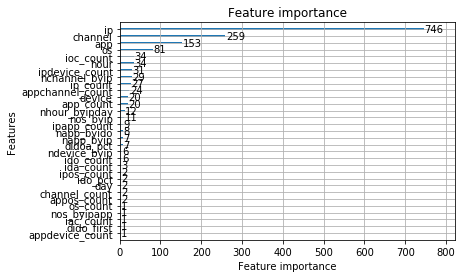

In [33]:
ax = lgb.plot_importance(bst2)
plt.show()

In [35]:
test = pd.read_csv('/Users/mengruiyin/Dropbox/project3/project3_coding/test_set.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [36]:
prediction2 = pd.read_csv('test_id.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [37]:
prediction2['is_attributed'] = bst2.predict(test[predictors],num_iteration=bst2.best_iteration)

In [39]:
prediction2.head()

,click_id,is_attributed
0,0,0.059810
1,1,0.068201
2,2,0.019954
3,3,0.048098
4,4,0.020567


In [41]:
prediction2.shape

(18790469, 2)

In [42]:
prediction2.to_csv('prediction2.csv', index = False)

In [3]:
model2 = pickle.load(open('model2.sav', 'rb'))

##### the auc score for prediction was 0.9657776, we could see the score has been improved a little bit. 
##### the next step would be changing features that couldn't help us to do prediction. 